In [1]:
import os
import yaml
import pickle
import matplotlib
from multiprocessing import Pool
from functools import partial

import torch
import numpy as np
import matplotlib.pyplot as plt
import bilby

import torch
import pandas as pd
from pprint import pprint

matplotlib.use('pdf')
os.environ['MPLCONFIGDIR'] = '/home/local/nihargupte'
import dingo.gw.dataset.generate_dataset 
from dingo.gw.inference import injection
import dingo.gw.training.train_builders
import dingo.gw.waveform_generator
from dingo.gw.ASD_dataset.noise_dataset import ASDDataset
from dingo.gw.dataset import WaveformDataset
from dingo.gw.domains import build_domain, build_domain_from_model_metadata
import dingo.gw.inference
from dingo.gw.transforms import SelectStandardizeRepackageParameters, RepackageStrainsAndASDS, UnpackDict, SampleExtrinsicParameters, GNPECoalescenceTimes, AddWhiteNoiseComplex
from dingo.core.models import PosteriorModel
import dingo.gw.domains
from dingo.gw.inference.gw_samplers import GWSamplerGNPE, GWSampler

from utils import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-wenistsd because the default path (/home/nihargupte/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
charizard_hex = ('#cd5241', '#084152', '#207394', '#eeb45a', '#e64110', '#ff524a', '#f6a410', '#08398b', '#626262', '#833118', '#eede7b')
plt.rcParams['text.usetex'] = False
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['font.size'] = 15
plt.rcParams['xtick.major.size'] = 4.0
plt.rcParams['xtick.minor.size'] = 3.0
plt.rcParams['ytick.major.size'] = 4.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=charizard_hex)

In [3]:
approximant = "SEOBNRv4HM_ROM"
special = "_O1_1024"
models_dir = "/home/local/nihargupte/dingo-devel/tutorials/03_aligned_spin"
train_dir = models_dir + f"/train_dir_{approximant}{special}"
waveform_generation_dir = (
    "/home/local/nihargupte/dingo-devel/tutorials/03_aligned_spin/datasets/waveforms"
)
os.environ[
    "LAL_DATA_PATH"
] = "/home/local/nihargupte/dingo-devel/venv/lib/python3.9/site-packages/lalsimulation/"

seob_device = 2
# build posterior model
torch.cuda.set_device(seob_device)
main_pm = PosteriorModel(
    device="cuda",
    **{"model_filename": f"{train_dir}/model_latest.pt"},
)

seob_time_pm = PosteriorModel(
    device='cuda',
    **{"model_filename": f"{models_dir}/train_dir_{approximant}{special}_time/model_latest.pt"}
)


Putting posterior model to device cuda.
Putting posterior model to device cuda.


In [30]:
def effective_spin(chi_1, chi_2, mass_ratio):
    a = chi_1 +  mass_ratio * chi_2
    b = 1 + mass_ratio
    return a / b

injection_parameters = {
    "mass_ratio": 0.8123393316195373,
    "chirp_mass": 30.48907067184531,
    "chi_1": 0.5,
    "chi_2": 0.3,
    "phase": 1.2,  # rad
    "theta_jn": 0,  # rad inclination to maximize effect of higher modes
    "psi": 0.7,  # rad
    "ra": 0.33,  # rad
    "dec": -0.6,  # rad
    "geocent_time": 0.0,  # s
    "luminosity_distance": 410,  # Mpc
}
total_mass = bilby.gw.conversion.chirp_mass_and_mass_ratio_to_total_mass(injection_parameters["chirp_mass"], injection_parameters["mass_ratio"])
mass_1, mass_2 = bilby.gw.conversion.total_mass_and_mass_ratio_to_component_masses(injection_parameters["mass_ratio"], total_mass)
injection_parameters = {
    **injection_parameters,
    "mass_1": mass_1,
    "mass_2": mass_2,
    "total_mass": total_mass,
    "effective_spin": effective_spin(injection_parameters["chi_1"], injection_parameters["chi_2"], injection_parameters["mass_ratio"])
}

In [32]:
os.environ["LAL_DATA_PATH"] = "/home/local/nihargupte/dingo-devel/venv/lib/python3.9/site-packages/lalsimulation/"

def check_priors(metadata, injection_parameters):
    assert eval(metadata["dataset_settings"]["intrinsic_prior"]["mass_ratio"]).minimum < injection_parameters["mass_ratio"].min()
    assert eval(metadata["dataset_settings"]["intrinsic_prior"]["mass_ratio"]).maximum > injection_parameters["mass_ratio"].max()
    assert eval(metadata["dataset_settings"]["intrinsic_prior"]["chirp_mass"]).maximum > injection_parameters["chirp_mass"].max()
    assert eval(metadata["dataset_settings"]["intrinsic_prior"]["chirp_mass"]).minimum < injection_parameters["chirp_mass"].min()

n_frames = 50
injection_parameters = {k:v*np.ones(n_frames) for k,v in injection_parameters.items()}
inj = injection_parameters.copy()
intrinsic_prior = main_pm.metadata["dataset_settings"]["intrinsic_prior"]
theta_sweep_dict = {"theta_jn": None, "mass_ratio": None, "total_mass": None}

# Defining theta_jn sweep
injection_parameters["theta_jn"] = np.linspace(0, np.pi / 2, n_frames)
theta_sweep_dict["theta_jn"] = pd.DataFrame(injection_parameters)
injection_parameters = inj.copy()

# Defining Mass Ratio Sweep keeping chirp mass fixed
injection_parameters["mass_ratio"] = np.linspace(0.2, 0.99, n_frames)
total_mass = bilby.gw.conversion.chirp_mass_and_mass_ratio_to_total_mass(injection_parameters["chirp_mass"], injection_parameters["mass_ratio"])
mass_1, mass_2 = bilby.gw.conversion.total_mass_and_mass_ratio_to_component_masses(injection_parameters["mass_ratio"], total_mass)
injection_parameters["mass_1"] = mass_1
injection_parameters["mass_2"] = mass_2
injection_parameters["total_mass"] = total_mass
check_priors(main_pm.metadata, injection_parameters)
theta_sweep_dict["mass_ratio"] = pd.DataFrame(injection_parameters)
injection_parameters = inj.copy()

# Defining Total Mass Sweep keeping mass ratio fixed 
min_chirp_mass = eval(intrinsic_prior["chirp_mass"]).minimum + 0.1
max_chirp_mass = eval(intrinsic_prior["chirp_mass"]).maximum
min_total_mass = bilby.gw.conversion.chirp_mass_and_mass_ratio_to_total_mass(min_chirp_mass, injection_parameters["mass_ratio"]).min()
print(min_total_mass, min_chirp_mass)
max_total_mass = bilby.gw.conversion.chirp_mass_and_mass_ratio_to_total_mass(max_chirp_mass, injection_parameters["mass_ratio"]).max()
injection_parameters["total_mass"] = np.linspace(min_total_mass, max_total_mass, n_frames)
mass_1, mass_2 = bilby.gw.conversion.total_mass_and_mass_ratio_to_component_masses(injection_parameters["mass_ratio"], injection_parameters["total_mass"])
chirp_mass = bilby.gw.conversion.component_masses_to_chirp_mass(mass_1, mass_2)
injection_parameters["mass_1"] = mass_1
injection_parameters["mass_2"] = mass_2
injection_parameters["chirp_mass"] = chirp_mass
check_priors(main_pm.metadata, injection_parameters)
theta_sweep_dict["total_mass"] = pd.DataFrame(injection_parameters)
injection_parameters = inj.copy()

# Defining Effective Spin Sweep 
# Effective spin is chi_eff = (chi_1 + q * chi_2) / (1 + q)
# We will do a 2D sweep grid with chi_1 = chi_2
n_frames = 50
injection_parameters = {k:np.resize(v, n_frames*n_frames) for k, v in injection_parameters.items()}
mass_ratio = np.linspace(0.2, 0.99, n_frames)
chi_1 = np.linspace(-1, 1, n_frames)
mass_ratio, chi_1 = np.meshgrid(mass_ratio, chi_1)
mass_ratio, chi_1 = mass_ratio.flatten(), chi_1.flatten()
injection_parameters["mass_ratio"] = mass_ratio
injection_parameters["chi_1"] = chi_1
injection_parameters["chi_2"] = chi_1
injection_parameters["effective_spin"] = effective_spin(injection_parameters["chi_1"], injection_parameters["chi_2"], injection_parameters["mass_ratio"])
total_mass = bilby.gw.conversion.chirp_mass_and_mass_ratio_to_total_mass(injection_parameters["chirp_mass"], injection_parameters["mass_ratio"])
mass_1, mass_2 = bilby.gw.conversion.total_mass_and_mass_ratio_to_component_masses(injection_parameters["mass_ratio"], total_mass)
injection_parameters["mass_1"] = mass_1
injection_parameters["mass_2"] = mass_2
injection_parameters["total_mass"] = total_mass
check_priors(main_pm.metadata, injection_parameters)
theta_sweep_dict["mass_ratio;effective_spin"] = pd.DataFrame(injection_parameters)
injection_parameters = inj.copy()


injection_generator = injection.Injection.from_posterior_model(main_pm)
domain = build_domain_from_model_metadata(main_pm.metadata)
asd_dataset = ASDDataset(file_name=main_pm.metadata["train_settings"]["training"]["stage_0"]["asd_dataset_path"])
asd = asd_dataset.sample_random_asds()
injection_generator.asd = asd
asd = injection_generator.asd

init_sampler = GWSampler(model=seob_time_pm)
sampler = GWSamplerGNPE(model=main_pm, init_sampler=init_sampler, num_iterations=5)

34.91579036494028 15.1

Loading dataset from /home/local/nihargupte/dingo-devel/tutorials/03_aligned_spin/datasets/ASDs_new/1024_1/asds_O1.hdf5.
GNPE parameters:  ['H1_time', 'L1_time']


In [33]:
def get_snr(domain, asd, strain_data, duration = 8.0):
    """
    Given an injection generated by Injection.injection or Injection.random_injection 
    will return snr of the injection in the two detectors

    Returns
    -------
    dict
        keys:
            detector: data (signal + noise) in each detector
    """
    snrs = {k:None for k in strain_data["waveform"].keys()}
    freq_snr_squared = {k:None for k in strain_data["waveform"].keys()}

    for ifo_name, ifo_signal in strain_data["waveform"].items():

        integrand = (np.conj(ifo_signal) * ifo_signal) / ((asd[ifo_name] ** 2) * domain.window_factor)
        freq_snr_squared[ifo_name] = (4 / duration) * integrand
        snrs[ifo_name] = ((4 / duration) * np.sum(integrand)) ** 0.5

    network_snr = np.sqrt(sum([snrs[ifo_name] ** 2 for ifo_name in strain_data["waveform"].keys()]))
    return snrs, freq_snr_squared, network_snr

def get_snr_bilby(domain, asd, strain_data, duration=8.0):
    from bilby.gw.detector import PowerSpectralDensity
    from bilby.gw.detector import InterferometerList

    ifos = InterferometerList(["H1", "L1"])
    ifos.time_duration = duration
    bilby_snr = 0
    for ifo in ifos:
        asd_array = asd[ifo.name]
        # This step is actually very important
        asd_array = asd_array.astype("float64")
        x_freq = domain.sample_frequencies.astype("float64")
        psd = PowerSpectralDensity(frequency_array=x_freq, asd_array=asd_array)
        ifo.power_spectral_density = psd
        # Making sure we aren't dropping anything due to precision
        assert np.min(asd_array**2) > 0
        ifo.set_strain_data_from_frequency_domain_strain(strain_data["waveform"][ifo.name], frequency_array=x_freq)
        ifo.strain_data.window_factor = domain.window_factor
        bilby_snr += ifo.optimal_snr_squared(signal=strain_data['waveform'][ifo.name])

    return bilby_snr ** 0.5

strain_data = injection_generator.signal(theta_sweep_dict["mass_ratio"].iloc[0])
print(get_snr(domain, asd, strain_data)[2])
print(get_snr_bilby(domain, asd, strain_data))

(12.393712534676377+0j)
(12.393712534676377+0j)


In [34]:
def rescale_snr_distance(target_snr, domain, parameters, asd, injection_generator):
    """ 
    Given a target network snr and parameters for a waveform, will rescale the luminosity distance, parameters["luminosity_distance"] such that now the network snr
    of the signal generated by parameters is the target_snr
    """
    def f(domain, asd, parameters, injection_generator, target_snr, d_L):
        parameters["luminosity_distance"] = d_L
        _, _, network_snr = get_snr(domain, asd, injection_generator.signal(parameters))
        return (target_snr - network_snr.real) ** 2
    
    g = partial(f, domain, asd, parameters, injection_generator, target_snr)
    res = scipy.optimize.minimize_scalar(g)
    parameters["luminosity_distance"] = res.x
    return parameters

target_snr = 14
for sweep_param, theta in theta_sweep_dict.items():
    print(sweep_param)
    for idx, parameters in theta.iterrows():
        theta_sweep_dict[sweep_param].iloc[idx] = rescale_snr_distance(target_snr, domain, parameters, asd, injection_generator)

theta_jn


/home/local/nihargupte/dingo-devel/dingo/gw/transforms/detector_transforms.py:79: RuntimeWarning: divide by zero encountered in true_divide
  hc = sample["waveform"]["h_cross"] * d_ref / d_new
/home/local/nihargupte/dingo-devel/dingo/gw/transforms/detector_transforms.py:79: RuntimeWarning: invalid value encountered in true_divide
  hc = sample["waveform"]["h_cross"] * d_ref / d_new
/home/local/nihargupte/dingo-devel/dingo/gw/transforms/detector_transforms.py:80: RuntimeWarning: divide by zero encountered in true_divide
  hp = sample["waveform"]["h_plus"] * d_ref / d_new
/home/local/nihargupte/dingo-devel/dingo/gw/transforms/detector_transforms.py:80: RuntimeWarning: invalid value encountered in true_divide
  hp = sample["waveform"]["h_plus"] * d_ref / d_new
/home/local/nihargupte/dingo-devel/dingo/gw/transforms/detector_transforms.py:88: RuntimeWarning: invalid value encountered in multiply
  strain = fp * hp + fc * hc


mass_ratio
total_mass
mass_ratio_effective_spin


In [35]:
# Ensuring that our new luminosity distance is still within the prior
for theta in theta_sweep_dict.values():
    print(f"Minimum d_L {theta['luminosity_distance'].min()}   Maximum d_L {theta['luminosity_distance'].max()}")
    assert eval(main_pm.metadata["train_settings"]["data"]["extrinsic_prior"]["luminosity_distance"]).minimum < theta["luminosity_distance"].min()
    assert eval(main_pm.metadata["train_settings"]["data"]["extrinsic_prior"]["luminosity_distance"]).maximum > theta["luminosity_distance"].max()

Minimum d_L 106.30443058217689   Maximum d_L 457.10729669790857
Minimum d_L 362.9587262454992   Maximum d_L 457.6965910803215
Minimum d_L 250.1244271311427   Maximum d_L 954.7373239539171
Minimum d_L 197.1393914640302   Maximum d_L 562.3625310724128


In [19]:
%%capture
class PosteriorList():
    def __init__(self, _num_samples, _num_avg_pts, _var_type, _approximant):
        self.approximant = _approximant
        self.num_samples = _num_samples
        self.num_avg_pts = _num_avg_pts
        self.var_type = _var_type
        self.posterior_dict = {}

    def append_var(self, var):
        self.posterior_dict[var] = {"truth" : None, "posteriors": None, "snr": None}

    def append_posterior(self, var, new_posterior):
        if self.posterior_dict[var]["posteriors"] == None:
            self.posterior_dict[var]["posteriors"] = {k:v.reshape(1, -1) for k,v in new_posterior.items()}
        else:
            for k in self.posterior_dict[var]["posteriors"].keys():
                posterior = np.concatenate([self.posterior_dict[var]["posteriors"][k], new_posterior[k].reshape(1, -1)], axis=0)
                self.posterior_dict[var]["posteriors"][k] = posterior

    def append_truth(self, var, truth):
        self.posterior_dict[var]["truth"] = truth

    def append_snr(self, var, snr):
        if self.posterior_dict[var]["snr"] == None:
            self.posterior_dict[var]["snr"] = {k:[v] for k,v in snr.items()}
        else:
            self.posterior_dict[var]["snr"] =  {k:v+[snr[k]] for k,v in self.posterior_dict[var]["snr"].items() }

    def __getitem__(self, idx, conflation = False): 
        return self.posterior_dict[list(self.posterior_dict.keys())[idx]]

    def get_mean(self, idx):
        posteriors = self.__getitem__(idx)["posteriors"]
        ret = {k:v.flatten().mean() for k, v in posteriors.items()}
        return ret

    def get_std(self, idx):
        posteriors = self.__getitem__(idx)["posteriors"]
        ret = {k:v.flatten().std() for k, v in posteriors.items()}
        return ret

    def __len__(self):
        return len(self.posterior_dict)

num_samples = 5_000
batch_size = 5_000
n_avg_pts = 1
posterior_sweep_dict = {k:None for k in theta_sweep_dict.keys()}
sweep_params = list(posterior_sweep_dict.keys())
plot_params = ["mass_ratio", "chirp_mass", "mass_1", "mass_2", "effective_spin"]
detectors = ["H1", "L1"]


for sweep_param, theta in theta_sweep_dict.items():
    seob_posterior_lst = PosteriorList(num_samples, n_avg_pts, sweep_param, "SEOBNRv4HM_ROM")
    for idx in range(len(theta)):
        np.random.seed(42)
        torch.manual_seed(42)
        strain_data = injection_generator.injection(theta.iloc[idx])

        seob_posterior_lst.append_var(theta[sweep_param][idx])
        truth = {k:strain_data["parameters"][k] for k in plot_params}
        seob_posterior_lst.append_truth(theta[sweep_param][idx], truth)
        
        for _ in range(n_avg_pts):
            sampler.context = strain_data.copy()
            sampler.run_sampler(
                num_samples=num_samples,
                batch_size=batch_size,
            )
            total_mass = bilby.gw.conversion.chirp_mass_and_mass_ratio_to_total_mass(sampler.samples["chirp_mass"], sampler.samples["mass_ratio"])
            mass_1, mass_2 = bilby.gw.conversion.total_mass_and_mass_ratio_to_component_masses(sampler.samples["mass_ratio"], total_mass)
            sampler.samples["mass_1"] = mass_1
            sampler.samples["mass_2"] = mass_2
            sampler.samples["effective_spin"] = effective_spin(sampler.samples["chi_1"], sampler.samples["chi_2"], sampler.samples["mass_ratio"])
            seob_posterior_lst.append_snr(theta[sweep_param][idx], {k:get_snr(domain, asd, strain_data)[0][k] for k in detectors})
            seob_posterior_lst.append_posterior(theta[sweep_param][idx], {k:sampler.samples[k].to_numpy() for k in plot_params})
    
    posterior_sweep_dict[sweep_param] = seob_posterior_lst


KeyboardInterrupt: 

TypeError: object of type 'NoneType' has no len()

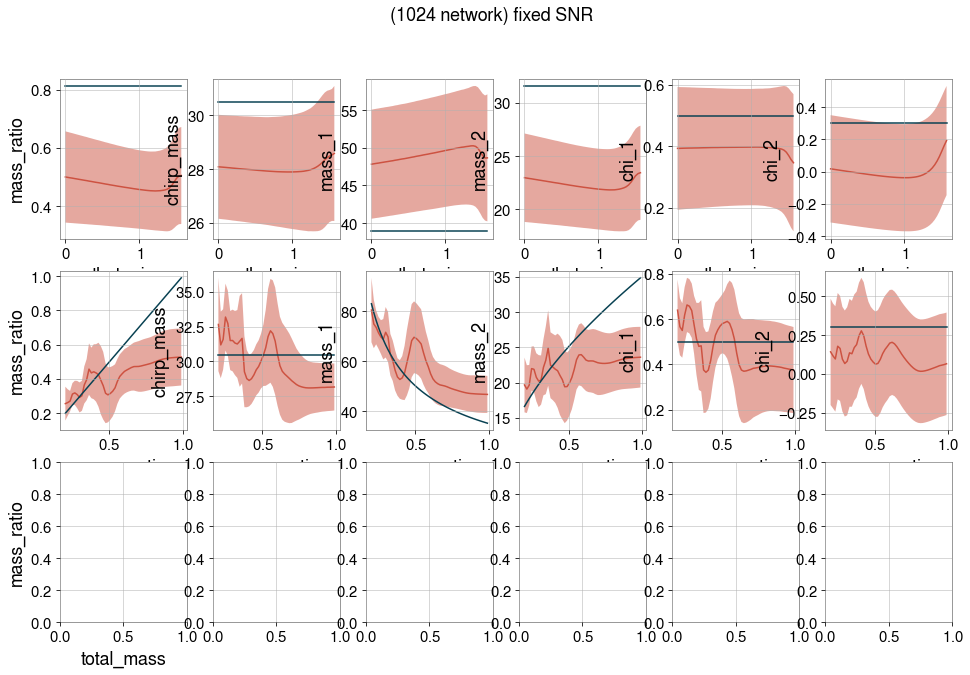

In [22]:
fig, axes = plt.subplots(len(sweep_params), len(plot_params), figsize=(16, 10))
fig.suptitle(f"({main_pm.metadata['train_settings']['data']['domain_update']['f_max']} network) fixed SNR")

for i in range(len(sweep_params)):
    for j in range(len(plot_params)):
        seob_posterior_lst = posterior_sweep_dict[sweep_params[i]]
        axes[i, j].set_xlabel(sweep_params[i])
        axes[i, j].set_ylabel(plot_params[j])
        avg = np.array([seob_posterior_lst.get_mean(idx)[plot_params[j]] for idx in range(len(seob_posterior_lst))])
        std = np.array([seob_posterior_lst.get_std(idx)[plot_params[j]] for idx in range(len(seob_posterior_lst))])
        axes[i, j].plot(list(seob_posterior_lst.posterior_dict.keys()), avg, label=r"SEOBNRv4HM_ROM $\pm 1 \sigma$")
        axes[i, j].fill_between(list(seob_posterior_lst.posterior_dict.keys()), avg - std, avg + std, alpha=0.5)
        axes[i, j].plot(list(seob_posterior_lst.posterior_dict.keys()), [seob_posterior_lst[i]["truth"][plot_params[j]] for i in range(len(seob_posterior_lst))], label="Truth")
        # plt.xticks(np.arange(0, np.pi + .1, step=(np.pi/4)), [r"0", r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$", r"$\frac{3 \pi}{4}$", r"$\pi$"])
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.tight_layout()
plt.savefig(f"/home/local/nihargupte/dingo-devel/tutorials/07_bias/saved_plots/{main_pm.metadata['train_settings']['data']['domain_update']['f_max']}.pdf")

In [32]:
for idx in range(len(seob_posterior_lst)):
    seob_posterior_lst[idx]["posteriors"]["effective_spin"] = effective_spin(seob_posterior_lst[idx]["posteriors"]["chi_1"], seob_posterior_lst[idx]["posteriors"]["chi_2"], seob_posterior_lst[idx]["posteriors"]["mass_ratio"])
    seob_posterior_lst[idx]["truth"]["effective_spin"] = effective_spin(seob_posterior_lst[idx]["truth"]["chi_1"], seob_posterior_lst[idx]["truth"]["chi_2"], seob_posterior_lst[idx]["truth"]["mass_ratio"])


In [33]:
%%capture
from chainconsumer import ChainConsumer
from matplotlib import gridspec
import scipy
from PIL import Image

N = 1

seob_posterior_lst = posterior_sweep_dict["mass_ratio"]
img_lst = []
for idx in range(len(seob_posterior_lst)):
    truth = seob_posterior_lst[idx]["truth"]
    c = ChainConsumer()
    c.add_chain(
        {
            k: seob_posterior_lst[idx]["posteriors"][k].flatten()
            for k in seob_posterior_lst[idx]["posteriors"].keys()
        },
        color=charizard_hex[0],
        name=seob_posterior_lst.approximant,
    )
    c.configure(
        linestyles=["-"] * N,
        linewidths=[1.5] * N,
        sigmas=[np.sqrt(2) * scipy.special.erfinv(x) for x in [0.5, 0.9]],
        shade=[False] + [True] * (N - 1),
        shade_alpha=0.3,
        bar_shade=False,
        label_font_size=10,
        tick_font_size=10,
        usetex=False,
        legend_kwargs={"fontsize": 30},
        kde=0.7,
    )

    fig = c.plotter.plot(
        truth=truth,
        extents={
            "mass_ratio": (0.125, 1),
            "chirp_mass": (15, 100),
            "chi_1": (-1, 1),
            "chi_2": (-1, 1),
            "theta_jn": (0, np.pi),
            "mass_1": (10, 300),
            "mass_2": (10, 100),
        },
    )
    fig.set_figwidth(10)
    fig.set_figheight(10)
    fig.savefig(
        f"/home/local/nihargupte/dingo-devel/tutorials/05_data_vis/dumps/mass_ratio_bias/{idx:03d}",
        dpi=300,
    )


: 

NameError: name 'seob_posterier_lst' is not defined

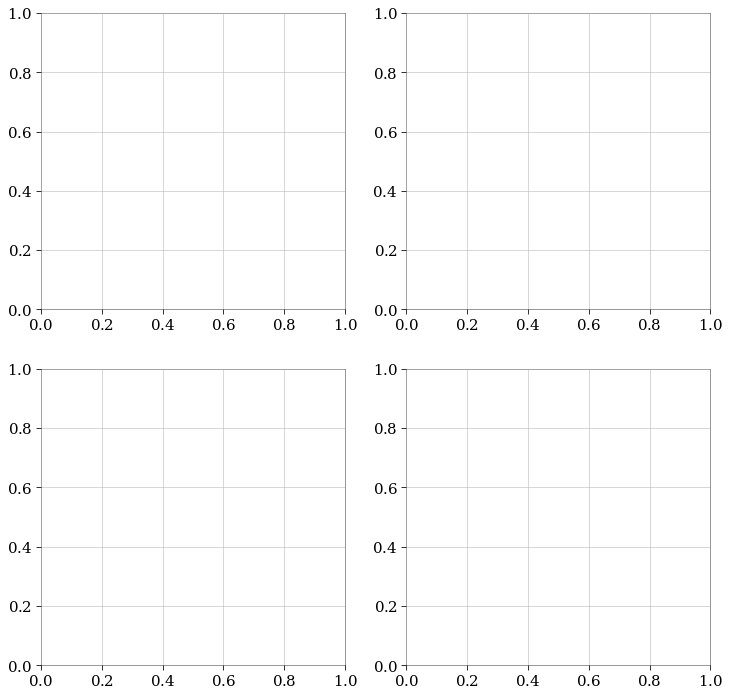

In [ ]:
# label = "mass_ratio"
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

for idx, label in enumerate(list(seob_posterier_lst.get_average(0).keys())):
    i, j  = int(f"{idx:02b}"[0]), int(f"{idx:02b}"[1])
    axes[i, j].set_xlabel("Mass Ratio")
    axes[i, j].set_ylabel(f"{label} bias")
    axes[i, j].plot(
        list(seob_posterier_lst.posterier_dict.keys()),
        [seob_posterier_lst.get_average(i)[label] - seob_posterier_lst[i]["truth"][label] for i in range(len(seob_posterier_lst))],
        label="SEOBNRv4HM_ROM"
    )

    # axes[i, j].plot(
    #     list(imrp_posterier_lst.posterier_dict.keys()),
    #     [imrp_posterier_lst.get_average(i)[label] - seob_posterier_lst[i]["truth"][label] for i in range(len(imrp_posterier_lst))],
    #     label="IMRPhenomXHM"
    # )
    axes[i, j].legend(fontsize=12)

fig.tight_layout()

plt.savefig("/home/local/nihargupte/dingo-devel/tutorials/05_data_vis/data_vis/mass_ratio_bias_1_1024.pdf")